In [1]:
import os
import sys
import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from glob import glob
import multiprocessing
import pandas as pd
from tqdm import tqdm
from copy import deepcopy
from hydra import initialize, compose
import matplotlib

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):  # ../../
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.plots import diagnostic_plot, plot
from mejiro.utils import util

In [2]:
# combine CSVs from each run into one CSV
data_dir = config.machine.dir_00
total_csv = os.path.join(data_dir, 'total_pop.csv')
detectable_csv = os.path.join(data_dir, 'detectable_pop.csv')
util.delete_if_exists(total_csv)
util.delete_if_exists(detectable_csv)
total_df = util.combine_all_csvs(data_dir, 'total', total_csv)
detectable_df = util.combine_all_csvs(data_dir, 'detectable', detectable_csv)

Wrote combined CSV to /data/bwedig/mejiro/pipeline/00/total_pop.csv
Wrote combined CSV to /data/bwedig/mejiro/pipeline/00/detectable_pop.csv


In [3]:
total_df.columns

Index(['velodisp', 'massstel', 'angleins', 'redssour', 'redslens', 'xposlens',
       'yposlens', 'xpossour', 'ypossour', 'numbimag', 'magnsour',
       'maxmdistimag', 'magtlensF106', 'magtsourF106', 'magtsourMagnifiedF106',
       'magtlensF129', 'magtsourF129', 'magtsourMagnifiedF129', 'magtlensF184',
       'magtsourF184', 'magtsourMagnifiedF184'],
      dtype='object')

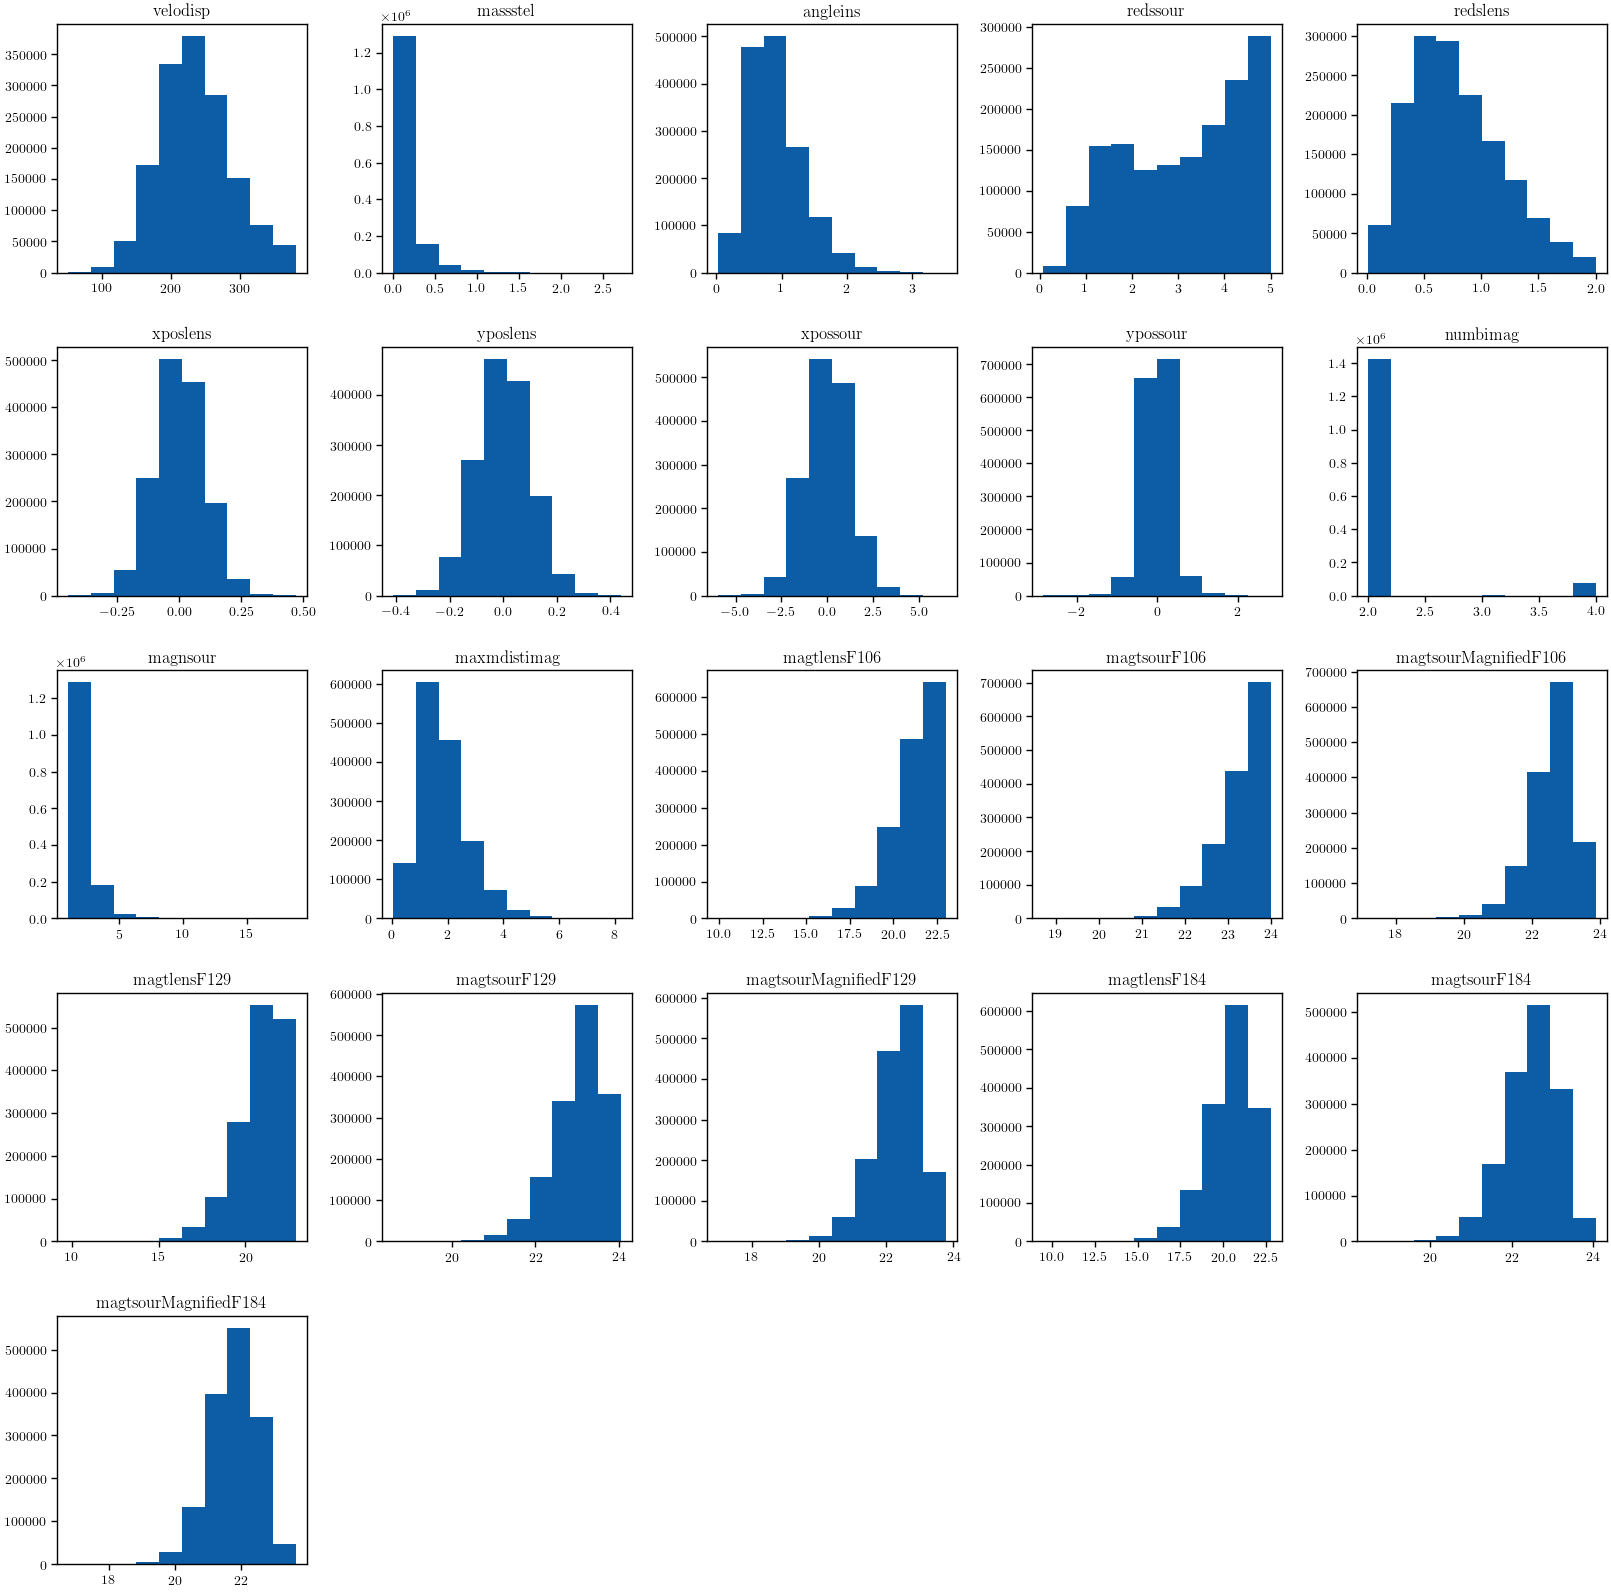

In [4]:
hist = total_df.hist(grid=False, figsize=(20, 20))

In [5]:
detectable_df.columns

Index(['velodisp', 'massstel', 'angleins', 'redssour', 'redslens', 'xposlens',
       'yposlens', 'xpossour', 'ypossour', 'numbimag', 'magnsour',
       'maxmdistimag', 'magtlensF106', 'magtsourF106', 'magtsourMagnifiedF106',
       'magtlensF129', 'magtsourF129', 'magtsourMagnifiedF129', 'magtlensF184',
       'magtsourF184', 'magtsourMagnifiedF184'],
      dtype='object')

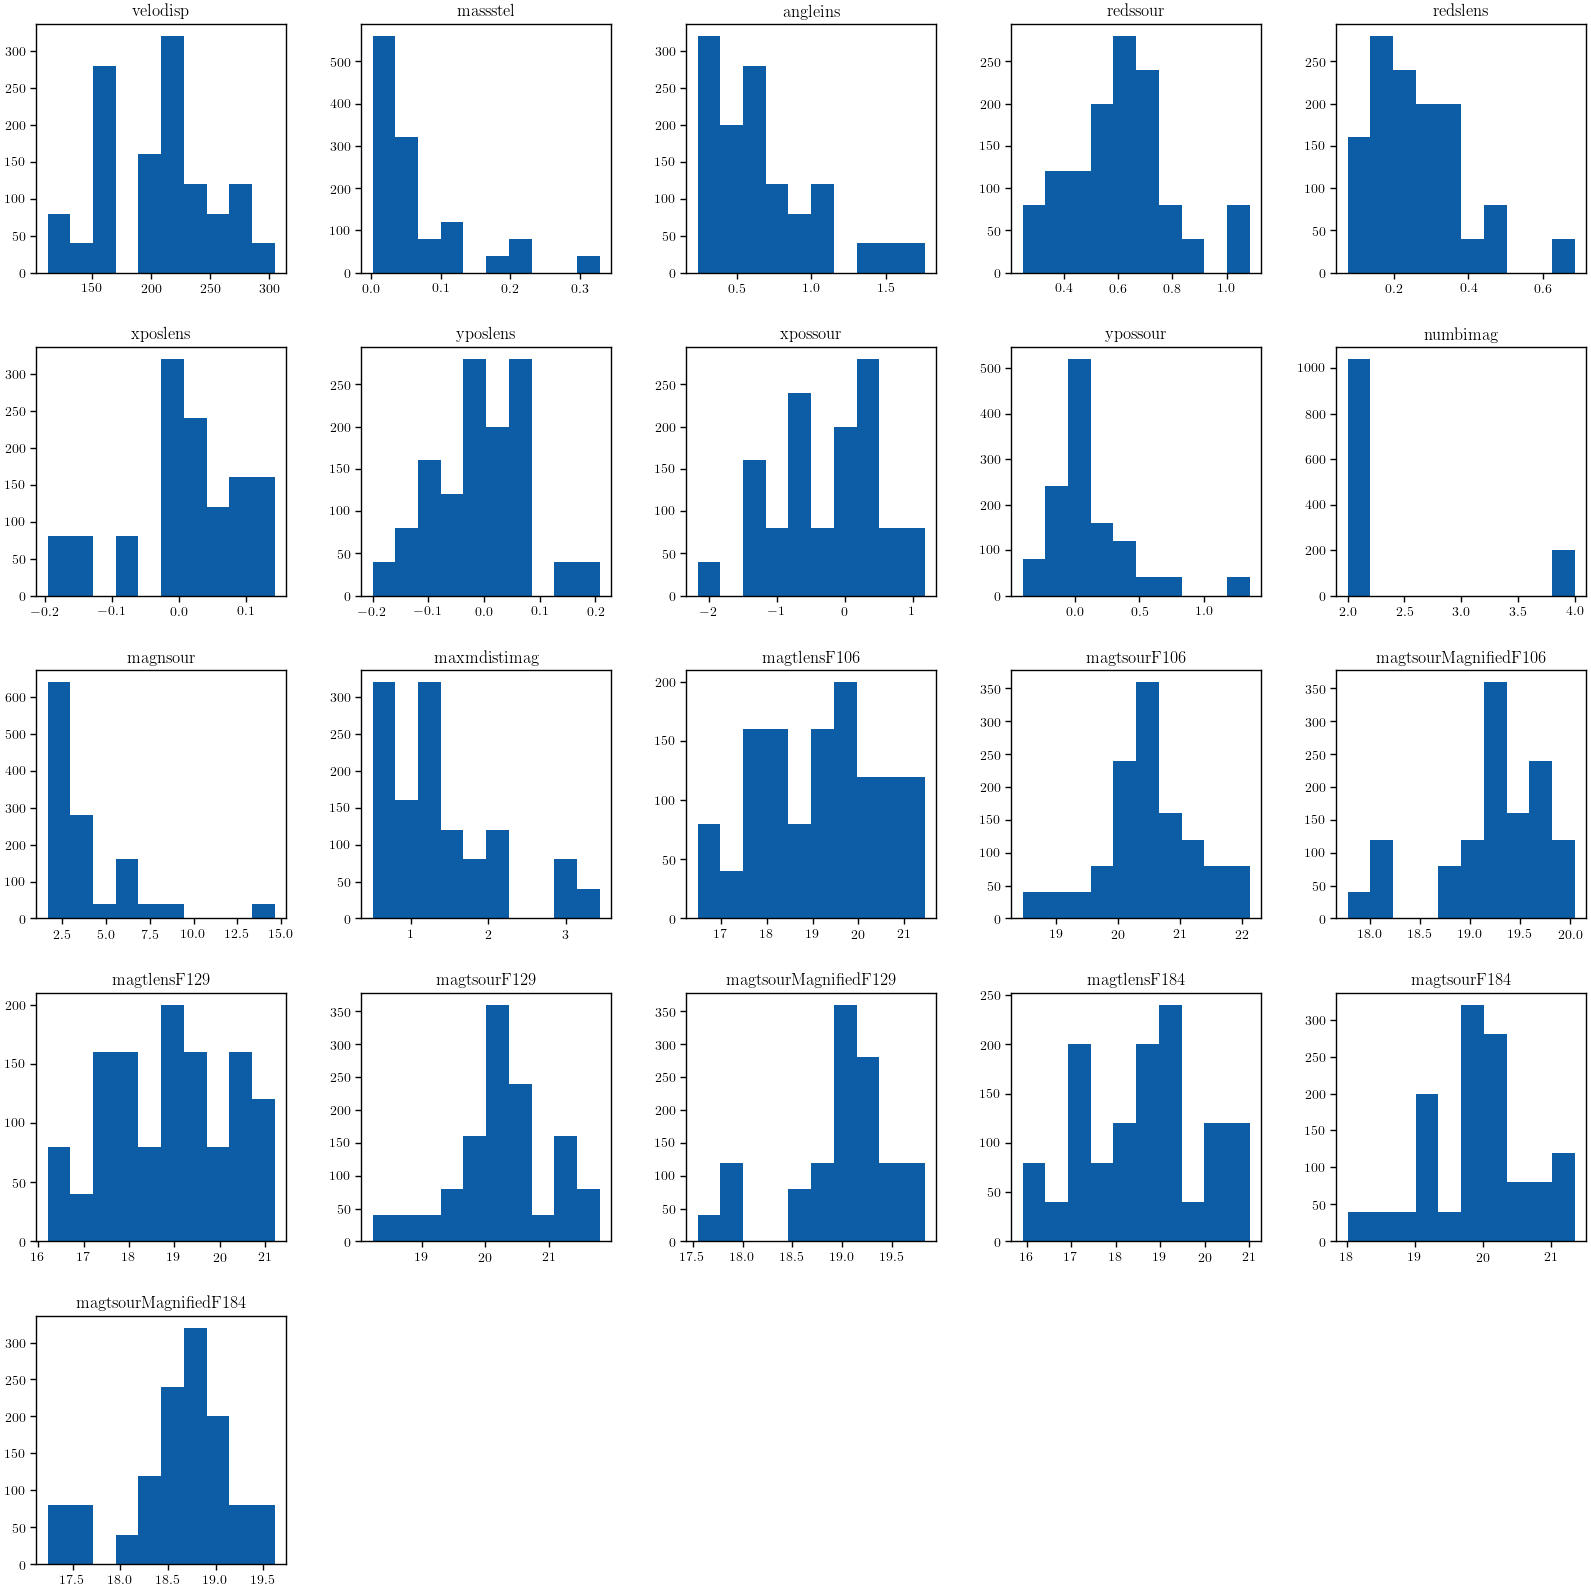

In [6]:
hist = detectable_df.hist(grid=False, figsize=(20, 20))

In [7]:
slacs_path = os.path.join(repo_dir, 'paper', 'supplemental', 'Bolton2008VizieR.csv')
slacs_df = pd.read_csv(slacs_path)

In [8]:
slacs_df.columns

Index(['recno', 'SDSS', 'Plate', 'MJD', 'Fiber', 'zFG', 'zBG', 'Imag',
       'n_Imag', 'AI', 'Name', 'L(V555)', 'Re', 'Le2/LdV', 'b/a', 'PA',
       'sigma', 'e_sigma', 'Mph', 'Mul', 'Lens', 'n_Lens', '_RA', '_DE'],
      dtype='object')

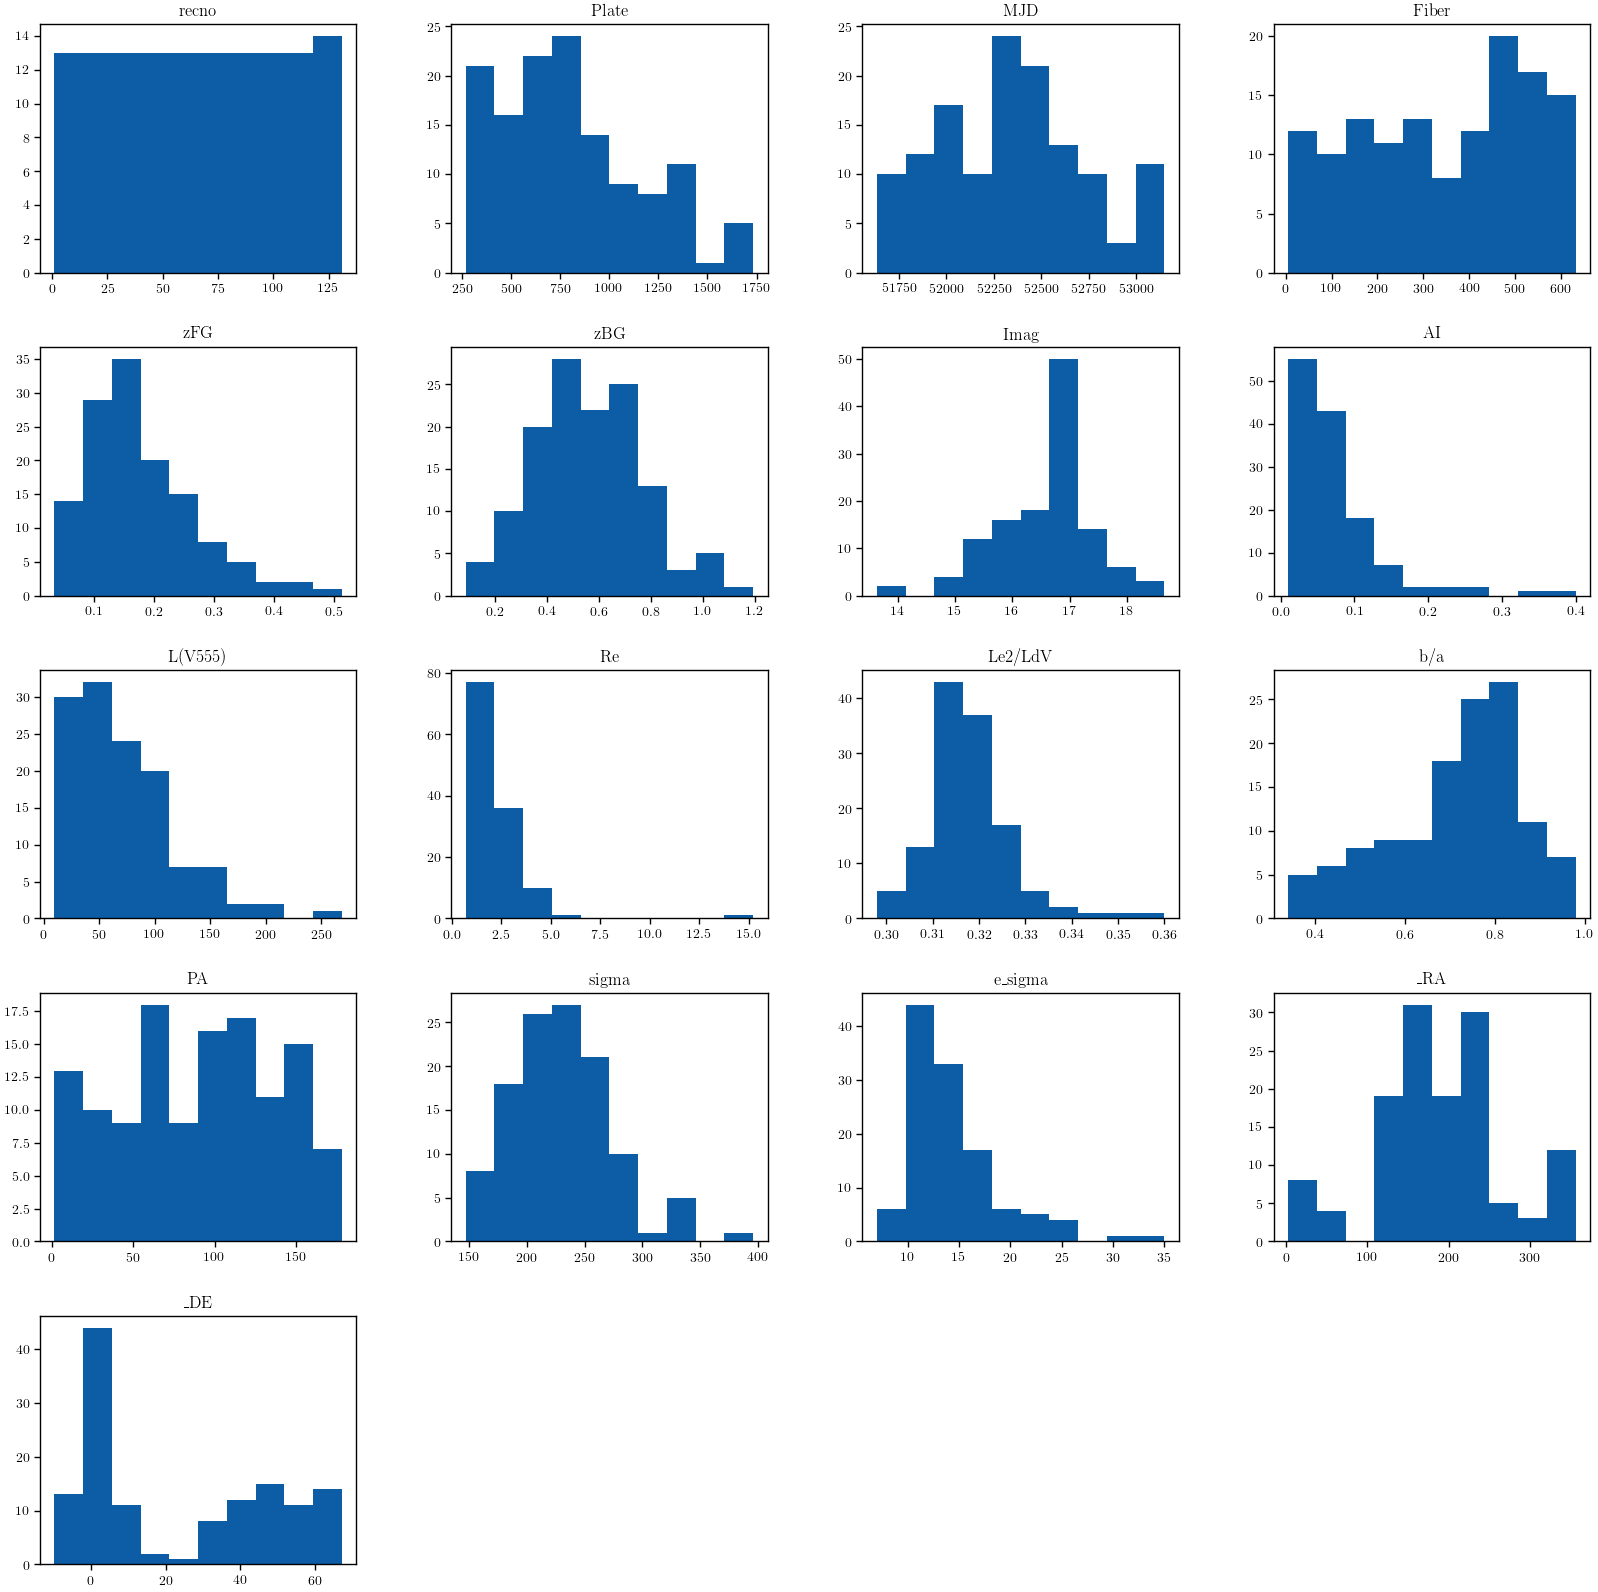

In [9]:
hist = slacs_df.hist(grid=False, figsize=(20, 20))
plt.savefig(os.path.join(figure_dir, 'slacs_hist.png'))

select histograms to show

In [10]:
# detectable lenses
velocity_dispersions = detectable_df.loc[:,'velodisp']
masses = detectable_df.loc[:,'massstel'] * 1e12
source_redshifts = detectable_df.loc[:,'redssour']
lens_redshifts = detectable_df.loc[:,'redslens']
einstein_radii = detectable_df.loc[:,'angleins']
num_images = detectable_df.loc[:,'numbimag']
source_magnitudes = detectable_df.loc[:,'magtsourF106']
lens_magnitudes = detectable_df.loc[:,'magtlensF106']
source_x = detectable_df.loc[:,'xpossour']
source_y = detectable_df.loc[:,'ypossour']
lens_x = detectable_df.loc[:,'xposlens']
lens_y = detectable_df.loc[:,'yposlens']

# total lenses
total_velocity_dispersions = total_df.loc[:,'velodisp']
total_masses = total_df.loc[:,'massstel'] * 1e12
total_source_redshifts = total_df.loc[:,'redssour']
total_lens_redshifts = total_df.loc[:,'redslens']
total_einstein_radii = total_df.loc[:,'angleins']
total_num_images = total_df.loc[:,'numbimag']
total_source_magnitudes = total_df.loc[:,'magtsourF106']
total_lens_magnitudes = total_df.loc[:,'magtlensF106']
total_source_x = total_df.loc[:,'xpossour']
total_source_y = total_df.loc[:,'ypossour']
total_lens_x = total_df.loc[:,'xposlens']
total_lens_y = total_df.loc[:,'yposlens']

# SLACS
slacs_velocity_dispersions = slacs_df.loc[:,'sigma']
slacs_source_redshifts = slacs_df.loc[:,'zBG']
slacs_lens_redshifts = slacs_df.loc[:,'zFG']

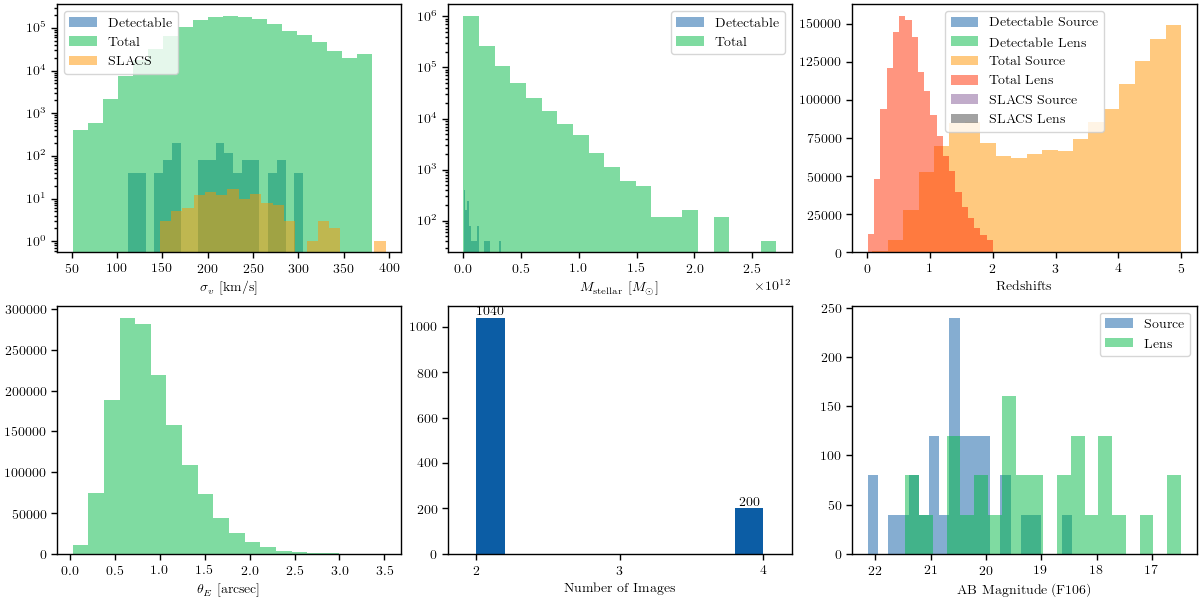

In [12]:
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 6), constrained_layout=True)
bins = 20

ax[0][0].hist(velocity_dispersions, label='Detectable', alpha=0.5, bins=bins)
ax[0][0].hist(total_velocity_dispersions, label='Total', alpha=0.5, bins=bins)
ax[0][0].hist(slacs_velocity_dispersions, label='SLACS', alpha=0.5, bins=bins)
ax[0][0].set_xlabel('$\sigma_v$ [km/s]')
ax[0][0].set_yscale('log')
ax[0][0].legend()

ax[0][1].hist(masses, label='Detectable', alpha=0.5, bins=bins)
ax[0][1].hist(total_masses, label='Total', alpha=0.5, bins=bins)
ax[0][1].set_xlabel(r'$M_{\textrm{stellar}}$ [$M_\odot$]')
ax[0][1].set_yscale('log')
ax[0][1].legend()

ax[0][2].hist(source_redshifts, label='Detectable Source', alpha=0.5, bins=bins)
ax[0][2].hist(lens_redshifts, label='Detectable Lens', alpha=0.5, bins=bins)
ax[0][2].hist(total_source_redshifts, label='Total Source', alpha=0.5, bins=bins)
ax[0][2].hist(total_lens_redshifts, label='Total Lens', alpha=0.5, bins=bins)
ax[0][2].hist(slacs_source_redshifts, label='SLACS Source', alpha=0.5, bins=bins)
ax[0][2].hist(slacs_lens_redshifts, label='SLACS Lens', alpha=0.5, bins=bins)
# ax[0][2].set_ylim([0, 250])
ax[0][2].set_xlabel('Redshifts')
ax[0][2].legend()

ax[1][0].hist(einstein_radii, label='Detectable', alpha=0.5, bins=bins)
ax[1][0].hist(total_einstein_radii, label='Total', alpha=0.5, bins=bins)
ax[1][0].set_xlabel(r'$\theta_E$ [arcsec]')

counts, edges, bars = ax[1][1].hist(num_images)
ax[1][1].set_xlabel('Number of Images')
labels = [int(v) if v > 0 else '' for v in counts]
ax[1][1].bar_label(bars, labels=labels, label_type='edge')
# ax[1][1].set_ylim([0, 1.2e3])  # make some space for the bar labels
ax[1][1].set_xlim([1.8, 4.2])  # make some space for the bar labels
ax[1][1].xaxis.set_major_locator(MaxNLocator(integer=True))

ax[1][2].hist(source_magnitudes, label='Source', alpha=0.5, bins=bins)
ax[1][2].hist(lens_magnitudes, label='Lens', alpha=0.5, bins=bins)
# ax[1][2].set_ylim([0, 250])
ax[1][2].set_xlabel('AB Magnitude (F106)')
ax[1][2].legend()
ax[1][2].invert_xaxis()

for each in ax.flatten()[2:]:  # skip the first two, which are on log scales
    each.ticklabel_format(axis='y', style='plain', scilimits=(0,0))

plt.savefig(os.path.join(figure_dir, 'skypy_pop_hist.png'))
plt.show()